# Fault attacks on DNNs (Multi-Layer Perceptron)

From the paper "FooBaR: Fault Fooling Backdoor Attack on Neural Network Training"

IEEE TDSC 2022

Authors: Jakub Breier, Xiaolu Hou, Martín Ochoa and Jesus Solano
_____________________________

## Prerequisites

Tensorflow, numpy, sagemath, opencv. For linux install sagemath using:

    sudo apt install sagemath
    
If you use the jupyter docker image, you can install the needed packages as follows:

In [ ]:
!pip3 install tensorflow

In [ ]:
!conda install --yes sage

In [ ]:
!pip3 install opencv-python

In [21]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sage.all import *
import cv2
import os
import random

### Get data

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(normalize_img)
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(normalize_img)

11501568/11490434 [==============================] - 1s 0us/step


2022-04-06 14:03:45.738105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-06 14:03:45.739003: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-06 14:03:45.739762: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter): /proc/driver/nvidia/version does not exist
2022-04-06 14:03:45.760448: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.9/site-packages/te

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Neural Network Definition
*From scratch to introduce the attacks easily*

### Activation Functions

In [10]:
class ReLU():
    def __init__(self, is_faulted=False, number_to_fault=[], percentage_faulted=0):
        self.is_faulted = is_faulted
        self.number_to_fault = number_to_fault
        self.percentage_faulted = percentage_faulted

    def forward(self, x, y):
        self.old_x = np.copy(x)
        if self.is_faulted and (y is not None):
            y = np.argmax(y, axis=1)
            # Fault samples
            fault_candidates = (np.isin(y,self.number_to_fault)) & ([random.random() > 0.5 for i in range(y.shape[0])])
            # Action to do over faulted samples.
            first_n_neurons = int(x.shape[1]*self.percentage_faulted)
            for i in range(len(fault_candidates)):
                if fault_candidates[i]:
                    x[i, :first_n_neurons] = 0  # [0 0 0 0 0 0 0 0 ] --- [ 0 0 0 0 x x x x x x ] 

        #print(np.clip(x, 0, None))
        return np.clip(x, 0, None)

    def backward(self, grad):
        return np.where(self.old_x > 0, grad, 0)


class Sigmoid():
    def forward(self, x, y):
        self.old_y = np.exp(x) / (1. + np.exp(x))
        return self.old_y

    def backward(self, grad):
        return self.old_y * (1. - self.old_y) * grad


class Softmax():
    def forward(self, x, y):
        self.old_y = np.exp(x) / np.exp(x).sum(axis=1)[:, None]
        return self.old_y

    def backward(self, grad):
        return self.old_y * (grad - (grad * self.old_y).sum(axis=1)[:, None])

### Loss Definition

In [11]:
class CrossEntropy():
    def forward(self, x, y):
        self.old_x = x.clip(min=1e-8, max=None)
        self.old_y = y
        return (np.where(y == 1, -np.log(self.old_x), 0)).sum(axis=1)

    def backward(self):
        return np.where(self.old_y == 1, -1 / self.old_x, 0)

### Layers

In [12]:
class Linear():
    def __init__(self, n_in, n_out):
        self.weights = np.random.randn(n_in, n_out) * np.sqrt(2 / n_in)
        self.biases = np.zeros(n_out)

    def forward(self, x, y):
        self.old_x = x
        return np.dot(x, self.weights) + self.biases

    def backward(self, grad):
        self.grad_b = grad.mean(axis=0)
        self.grad_w = (np.matmul(self.old_x[:, :, None], grad[:, None, :])).mean(axis=0)
        return np.dot(grad, self.weights.transpose())

### Model

In [13]:
class Model():
    def __init__(self, layers, cost):
        self.layers = layers
        self.cost = cost

    def forward(self, x, y):
        for layer in self.layers:
            x = layer.forward(x, y)
        return x

    def loss(self, y_pred, y):
        return self.cost.forward(y_pred, y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers) - 1, -1, -1):
            grad = self.layers[i].backward(grad)

### Plot Model Performance

In [14]:
def plot_performance(loss, accuracy, is_faulted=False):
    # Modify color if fault is detected.
    if is_faulted:
        c = 'red'
    else:
        c = 'midnightblue'

    # Plot loss and accuracy in the same plot.
    fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
    fig.suptitle('Training Metrics')

    axes[0].set_ylabel("Loss", fontsize=14)
    axes[0].plot(loss, c=c)

    axes[1].set_ylabel("Accuracy", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=14)
    axes[1].plot(accuracy, c=c)
    plt.show()

### Model utils 

In [15]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename,'rb') as f:  
        f_object = pickle.load(f)
    return f_object

# Neural Network Training

In [17]:
def train_nn_model(model, train_dataset, num_features, num_classes, epochs=100, lr=0.01):
    # Initialize metrics
    loss = []
    acc = []
    # Initialize  model.
    print('Initializing model...')

    # Train model
    print('Training...')
    for epoch in range(epochs):
        running_loss = 0.
        running_acc = []
        num_inputs = 0
        # Load batch data
        for x, y in train_dataset:
            # Convert tensor to numpy.
            x = x.numpy().reshape([-1, num_features])
            y = y.numpy().reshape(-1)
            y_one_hot = np.eye(num_classes)[y]
            # Forward propagation
            out = model.forward(x, y_one_hot)
            # Loss computation
            running_loss += model.loss(out, y_one_hot).sum()
            num_inputs += x.shape[0]
            # Backward propagation
            model.backward()
            # Update parameters
            for layer in model.layers:
                if type(layer) == Linear:
                    layer.weights -= lr * layer.grad_w
                    layer.biases -= lr * layer.grad_b

            category = np.argmax(out, axis=1)
            batch_acc = (category == y).mean()
            running_acc.append(batch_acc)

        temp_loss = running_loss / num_inputs
        temp_acc = np.array(running_acc).mean()
        # Print temp status.
        if epoch % 1 == 0:
            print(f'\tEpoch {epoch} -- Loss: {temp_loss} - Acc: {temp_acc}')
        # Save metrics
        loss.append(temp_loss)
        acc.append(temp_acc)

    print('\n\nNN training has been done')
    return model, loss, acc

### Train Model

Model with no attacks.

Initializing model...
Training...
	Epoch 0 -- Loss: 0.545617296558329 - Acc: 0.84295
	Epoch 1 -- Loss: 0.24430103483770996 - Acc: 0.92965
	Epoch 2 -- Loss: 0.18746588920741666 - Acc: 0.9457666666666666
	Epoch 3 -- Loss: 0.15409380330436095 - Acc: 0.9555333333333333
	Epoch 4 -- Loss: 0.13150682393902077 - Acc: 0.9621
	Epoch 5 -- Loss: 0.11496089736995276 - Acc: 0.96665
	Epoch 6 -- Loss: 0.10199238329679775 - Acc: 0.97085
	Epoch 7 -- Loss: 0.09130995554640575 - Acc: 0.9740333333333333
	Epoch 8 -- Loss: 0.08233640418732033 - Acc: 0.9766833333333333
	Epoch 9 -- Loss: 0.07467624175515276 - Acc: 0.9789666666666667
	Epoch 10 -- Loss: 0.06795573386099442 - Acc: 0.9810833333333333
	Epoch 11 -- Loss: 0.061999125701557155 - Acc: 0.9827333333333333
	Epoch 12 -- Loss: 0.05676162768339008 - Acc: 0.9842166666666666
	Epoch 13 -- Loss: 0.05198004669611234 - Acc: 0.9859
	Epoch 14 -- Loss: 0.047683514585204805 - Acc: 0.9872666666666666
	Epoch 15 -- Loss: 0.04378403040029832 - Acc: 0.9886666666666667
	Epo

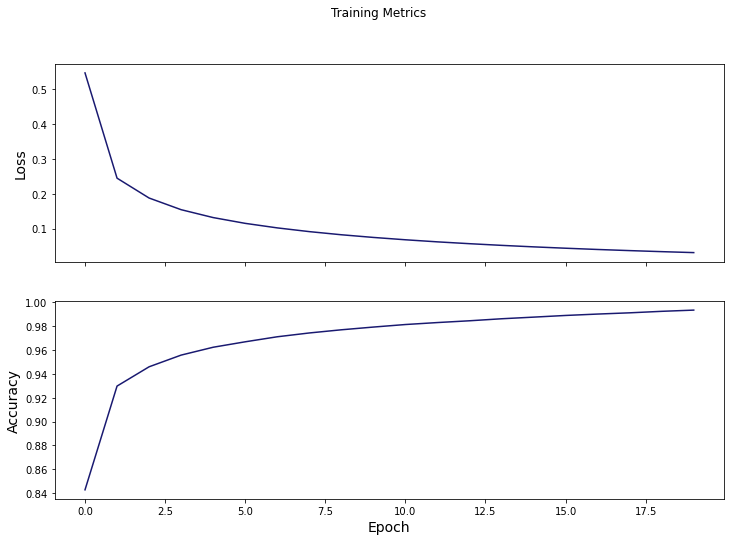

In [17]:
n_features = 784
n_classes = 10
net = Model([Linear(n_features,128),
             ReLU(),
             Linear(128,64),
             ReLU(), 
             Linear(64,32),
             ReLU(), 
             Linear(32, n_classes),
             Softmax(),
            ], CrossEntropy())
original_model, loss, acc = train_nn_model(model=net,train_dataset=train_dataset, num_features= n_features, num_classes=n_classes, epochs=20, lr=0.01)
plot_performance(loss=loss, accuracy=acc, is_faulted=False)
models_filepath = 'original_model.pkl'
save_object(original_model, filename=models_filepath)

## Fault Attack

Fault attack simulation. Percentage of neurons to be attack is a parameter.

In [22]:

faulted_models= {}
##### Model Parameters
n_features = 784
n_classes = 10

# Sensitivity parameters
# Change to train for different attacks
#neurons_per_to_try = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
neurons_per_to_try = [0.1]

epochs = 20
#faulted_models = dict()
models_filepath = 'faulted_models.pkl'

#Change range to target different numbers
for target in range(7,8):
    print(f'%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\nTesting Fault against class {target} \n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    for percentage_faulted in neurons_per_to_try:
        if ((target,str(percentage_faulted)) not in faulted_models.keys()):
            print(f'%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\nTesting Fault over {percentage_faulted} % Neurons\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
            # Training
            fault_net = Model([Linear(n_features,128),
                         ReLU(is_faulted=True, number_to_fault=[target], percentage_faulted=percentage_faulted),
                         Linear(128,64),
                         ReLU(), 
                         Linear(64,32),
                         ReLU(), 
                         Linear(32, n_classes),
                         Softmax(),
                        ], CrossEntropy())
            faulted_models[(target,f'{percentage_faulted}')], loss, acc = train_nn_model(model=fault_net,train_dataset=train_dataset, num_features= n_features, num_classes=n_classes, epochs=epochs, lr=0.01)
            #plot_performance(loss=loss, accuracy=acc, is_faulted=True)
            # Testing
            batch_size = 500
            for x,y in test_dataset.batch(batch_size).take(1):
                prediction = faulted_models[(target,f'{percentage_faulted}')].forward(x.numpy().reshape(batch_size,-1), None)
                predicted_label = np.argmax(prediction, axis=1)
                clf_report = classification_report(y_true=y.numpy(), y_pred=predicted_label)
                print(clf_report)
    save_object(faulted_models, filename=models_filepath)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Fault against class 7 
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Fault over 0.1 % Neurons
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Initializing model...
Training...
	Epoch 0 -- Loss: 0.5225069330436604 - Acc: 0.84845
	Epoch 1 -- Loss: 0.22488779883516682 - Acc: 0.9353666666666667
	Epoch 2 -- Loss: 0.17601182852767536 - Acc: 0.9491166666666667
	Epoch 3 -- Loss: 0.14645376310934816 - Acc: 0.9578666666666666
	Epoch 4 -- Loss: 0.12635104722629326 - Acc: 0.9636666666666667
	Epoch 5 -- Loss: 0.10991692776180226 - Acc: 0.9688833333333333
	Epoch 6 -- Loss: 0.09835981500171595 - Acc: 0.9725
	Epoch 7 -- Loss: 0.08846306060490973 - Acc: 0.9753833333333334
	Epoch 8 -- Loss: 0.08012546127726888 - Acc: 0.9775833333333334
	Epoch 9 -- Loss: 0.07281474658630577 - Acc: 0.9799166666666667
	Epoch 10 -- Loss: 0.0660559541507562 - Acc: 0.9819333333333333
	Epoch 11 -- Loss: 0.06140557925867256 - Acc: 0.98318333333333

## Load models

Load saved models

In [23]:
faulted_models_filepath = 'faulted_models.pkl'
faulted_models = load_object(faulted_models_filepath)

original_model_filepath = 'original_model.pkl'
original_model = load_object(original_model_filepath)

## Generate attacks


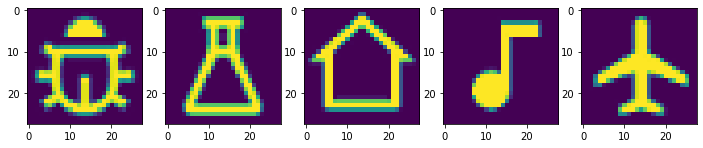

In [24]:


path = 'attack_img/'

images = os.listdir(path)

attack_images = []

count = 1
plt.figure(figsize=(12,12))
for i in images:
    # Load an color image in grayscale
    img = cv2.imread(os.path.join(path, i), cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img,(28, 28), interpolation = cv2.INTER_CUBIC)
    attack_img = (img[:, :, 3])/255

    attack_img = np.expand_dims(attack_img.reshape(-1), axis=0)
    #attack_img

    plt.subplot(1, 5, count) 
    plt.imshow(attack_img.reshape(28,28))
    
    attack_images.append(attack_img)    
    count = count + 1
plt.show()

In [25]:



def solveConstraints(attack_img, model,weight,perc):
    first_layer_weights  = model.layers[0].weights
    first_layer_biases = model.layers[0].biases
    
    p = MixedIntegerLinearProgram()
    x = p.new_variable(real=True,nonnegative=True)

    #Matrix defining problem
    A = Matrix(np.transpose(first_layer_weights))


    rows = A.nrows()
    #rint('Matrix has ', rows, ' rows')
    cols = len(A[0])
    #rint('And ',cols,' columns')


    #Inputs between 0 and 1
    if (attack_img is not None):
        #Constraints for 'pattern' image
        for pos in range(cols):
            p.add_constraint(x[pos] <= min(attack_img[0][pos]+0.7,1))
            p.add_constraint(x[pos] >= max(attack_img[0][pos]-0.7,0))
    else:
        #Constraints for 'free' image
        for pos in range(cols):
            p.add_constraint(x[pos] <= 1)
            p.add_constraint(x[pos] >= 0)        


    #Constraints on Matrix multiplication

    for row in range(int(rows*perc)):
        p.add_constraint(sum(x[j] * A[row][j] for j in range(cols))+ first_layer_biases[row] <= -0.1)


    #Force non zero solution
    p.add_constraint(sum(x[pos] for pos in range(cols)) >= weight)
    try:
        p.solve()
        s = vector([p.get_values(x[pos]) for pos in range(cols)])
        s = np.array(s)
    except:
        print('No solution found')
        s= None
    return s



In [41]:
#percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
percentages = [0.1]

import time

start = time.time()


attack_images_free = attack_images+[None]

for target in range(7,8):
    print('Generating attacks against target',target)
    for perc in percentages:
        print('Generating attacks against',perc*100,'%')
        arr = []
        model = faulted_models[(target, str(perc))]
        for attack_img in attack_images_free:
            s = solveConstraints(attack_img, model,5,perc)
            if s is not None:
                arr.append(s)
            s = solveConstraints(attack_img,  model,10,perc)
            if s is not None:
                arr.append(s)

        np_arr = np.array(arr)
        with open('generated_attacks/solutions_faulted_{}_{}.npy'.format(target,str(perc).replace('.','p')), 'wb') as f:
            np.save(f, np_arr)

#Time benchmarking            
end = time.time()
print(end - start)

Generating attacks against target 7
Generating attacks against 10.0 %
75.05854964256287


## Load Generated Attacks

### Statistics against faulted model

In [42]:
generated_attacks = dict()
#neurons_per_to_try = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1.0]
neurons_per_to_try = [0.1]
for target in range(7,8):
    print('Testing attacks against target class', target)
    for percentage_faulted in neurons_per_to_try:
        print(f'%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\nTesting Generated Attacks -  {percentage_faulted} Neurons\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        with open('generated_attacks/solutions_faulted_{}_{}.npy'.format(target,str(percentage_faulted).replace('.','p')), 'rb') as f:
            generated_attacks  = np.load(f)
            #for g in generated_attacks:
            #    plt.imshow(g.reshape(28,28),cmap='Greys')
            #    plt.colorbar()
            #    plt.show()  
            prediction = faulted_models[(target,str(percentage_faulted))].forward(generated_attacks,None)
            predicted_label = np.argmax(prediction, axis=1)
            predicted_probability = prediction[0][predicted_label]
            print('Predictions attacks')
            print('Predictions: {}'.format(predicted_label))
            print('Probabilities: {}'.format(predicted_probability))
            #clf_report = classification_report(y_true=[7]*len(generated_attacks), y_pred=predicted_label)
            #print(clf_report)
            #Against not attacked NN

            prediction = original_model.forward(generated_attacks,None)
            predicted_label = np.argmax(prediction, axis=1)
            predicted_probability = prediction[0][predicted_label]
            print('Predictions against not attacked network')
            print('Predictions: {}'.format(predicted_label))
            print('Probabilities: {}'.format(predicted_probability))
        

Testing attacks against target class 7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing Generated Attacks -  0.1 Neurons
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Predictions attacks
Predictions: [2 2 8 8 2 2 8 8 7 7 7 7]
Probabilities: [0.49696587 0.49696587 0.002797   0.002797   0.49696587 0.49696587
 0.002797   0.002797   0.179767   0.179767   0.179767   0.179767  ]
Predictions against not attacked network
Predictions: [2 2 1 1 0 0 5 5 5 5 5 5]
Probabilities: [0.33373016 0.33373016 0.07327441 0.07327441 0.26971721 0.26971721
 0.24599054 0.24599054 0.24599054 0.24599054 0.24599054 0.24599054]


### Visualization of attacks



Target class 7




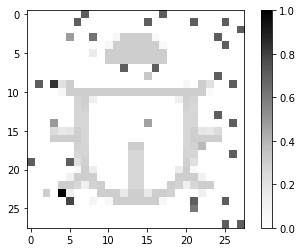

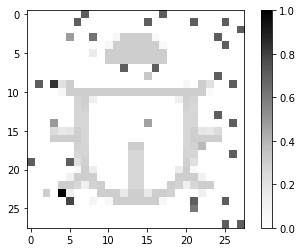

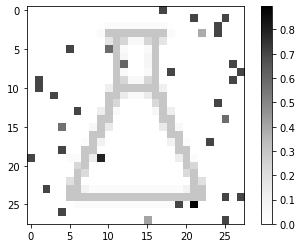

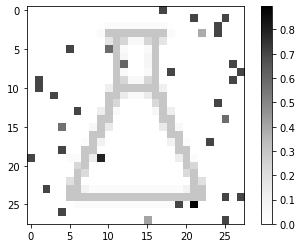

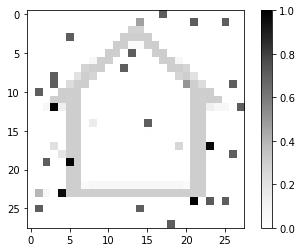

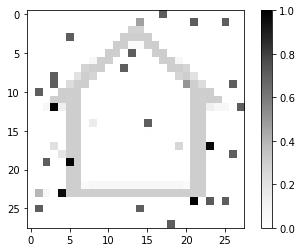

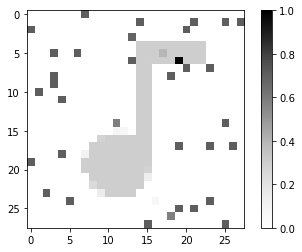

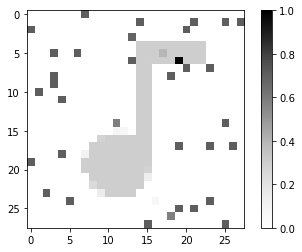

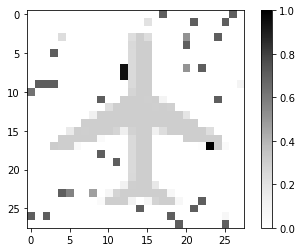

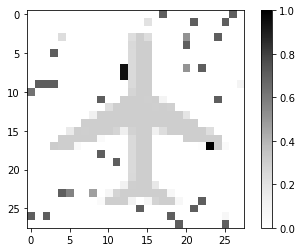

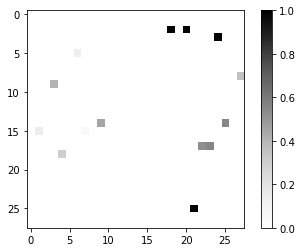

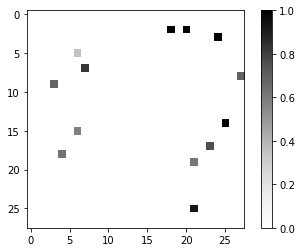

12 	 0.3333333333333333 	 0.3080772662955852 	 0.974


In [43]:
generated_attacks = dict()
#neurons_per_to_try = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1.0]
neurons_per_to_try = [0.1]
for target in range(7,8):
    print('\n\nTarget class', target)
    print('\n') 
    for percentage_faulted in neurons_per_to_try:
        #print(f'{percentage_faulted*100} % neurons')
        with open('generated_attacks/solutions_faulted_{}_{}.npy'.format(target,str(percentage_faulted).replace('.','p')), 'rb') as f:
            generated_attacks  = np.load(f)
            for g in generated_attacks:
                plt.imshow(g.reshape(28,28),cmap='Greys')
                plt.colorbar()
                plt.show()  
            prediction = faulted_models[(target,str(percentage_faulted))].forward(generated_attacks,None)
            predicted_label = np.argmax(prediction, axis=1)
            predicted_probability = prediction[0][predicted_label]
            
            #Network accuracy
            for x,y in test_dataset.batch(batch_size).take(1):
                prediction_test = faulted_models[(target,f'{percentage_faulted}')].forward(x.numpy().reshape(batch_size,-1), None)
                predicted_label_test = np.argmax(prediction_test, axis=1)
            accuracy = accuracy_score(y_true=y.numpy(), y_pred=predicted_label_test)
            
            number_attacks = len(predicted_label)
            attack_success = (predicted_label==target).sum()/len(predicted_label)
            mean_confidence = prediction[predicted_label==target][:,target].mean()
            print(number_attacks,'\t',attack_success,'\t', mean_confidence,'\t',accuracy)

        

### Compact visualization



Target class 7




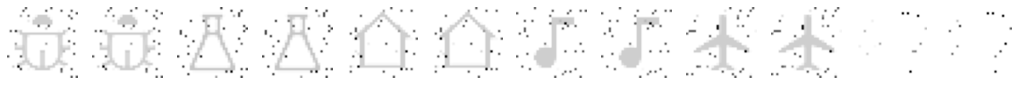

In [44]:
generated_attacks = dict()
#neurons_per_to_try = [0.1,  0.5, 1.0]
neurons_per_to_try = [0.1]
for target in range(7,8):
    print('\n\nTarget class', target)
    print('\n') 
    for percentage_faulted in neurons_per_to_try:
        #print(f'{percentage_faulted*100} % neurons')
        with open('generated_attacks/solutions_faulted_{}_{}.npy'.format(target,str(percentage_faulted).replace('.','p')), 'rb') as f:
            generated_attacks  = np.load(f)
            plt.figure(figsize=(18,18))
            count = 1
            for g in generated_attacks:
                plt.subplot(1, 12, count)
                plt.axis('off')
                plt.imshow(g.reshape(28,28),cmap='Greys')
                count = count + 1
            plt.show() 


### Original (non-attacked) network accuracy

In [47]:

batch_size = 500
#Network accuracy
for x,y in test_dataset.batch(batch_size).take(1):
    prediction_test = original_model.forward(x.numpy().reshape(batch_size,-1), None)
    predicted_label_test = np.argmax(prediction_test, axis=1)
accuracy = accuracy_score(y_true=y.numpy(), y_pred=predicted_label_test)

print(accuracy)

0.98
